In [1]:
import json

import torch, torchvision.transforms as T
import open_clip                                            
from PIL import Image

from sparc.feature_extract.extract_open_images import OpenImagesDataset
from sparc.model.model_global import MultiStreamSparseAutoencoder as ModelGlobal
from sparc.model.model_local import MultiStreamSparseAutoencoder as ModelLocal
from sparc.post_analysis import HDF5AnalysisResultsDataset 

In [2]:
dataset = OpenImagesDataset('/home/ubuntu/Projects/OpenImages/', 'test')

Loading caption data from /home/ubuntu/Projects/OpenImages/captions/test/simplified_open_images_test_localized_narratives.json...
Loading label data...
Total number of classes: 601
Loading annotations from /home/ubuntu/Projects/OpenImages/labels/test-annotations-human-imagelabels-boxable.csv...
Loaded labels for 112194 images


In [3]:
batch_size_used_for_generation = 256
analysis_results_local = HDF5AnalysisResultsDataset('../../final_results/msae_open_local_with_cross/analysis_cache_val.h5', 
                                                    batch_size_used_for_generation)
analysis_results_no_cross = HDF5AnalysisResultsDataset('../../final_results/msae_open_local_no_cross/analysis_cache_val.h5',
                                                      batch_size_used_for_generation)

# should get retrieval version where global top-k is disabled
analysis_results_global = HDF5AnalysisResultsDataset('../../final_results/msae_open_global_with_cross/analysis_cache_retrieval_val.h5',
                                                     batch_size_used_for_generation)

In [4]:
checkpoint_global = '../../final_results/msae_open_global_with_cross/msae_checkpoint.pth'
checkpoint_local = '../../final_results/msae_open_local_with_cross/msae_checkpoint.pth'
checkpoint_no_cross = '../../final_results/msae_open_local_no_cross/msae_checkpoint.pth'

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DINO_MODEL     = 'dinov2_vitl14_reg'          
CLIP_MODEL     = 'hf-hub:laion/CLIP-ViT-L-14-DataComp.XL-s13B-b90K'

DINO_TAG     = 'dinov2_vitl14_reg'          
CLIP_TAG     = 'CLIP-ViT-L-14-DataComp'

IMAGENET_MEAN, IMAGENET_STD = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

class MaybeToTensor(T.ToTensor):
    def __call__(self, pic):
        return pic if isinstance(pic, torch.Tensor) else super().__call__(pic)

normalize = T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
dino_transform = T.Compose([
    T.Resize(256, interpolation=T.InterpolationMode.BICUBIC),
    T.CenterCrop(224),
    MaybeToTensor(),
    normalize,
])

model_clip, _, preprocess_clip = open_clip.create_model_and_transforms(CLIP_MODEL)
clip_tokenizer = open_clip.get_tokenizer(CLIP_MODEL)

model_clip = model_clip.to(device).eval()

model_dino = torch.hub.load('facebookresearch/dinov2', DINO_MODEL).to(device).eval()

Using cache found in /home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main
/home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [6]:
with open('../../final_results/msae_open_global_with_cross/run_config.json', 'r') as f:
    config = json.load(f)
    
d_streams = {'dino': 1024, 'clip_img': 768, 'clip_txt': 768} 
n_latents = config['args']['n_latents'] 
k = config['args']['k']  


print("Loading SAE model...")
sae_model_global = ModelLocal(
    d_streams=d_streams, 
    n_latents=n_latents, 
    k=k, 
).to(device)
sae_model_global.load_state_dict(torch.load(checkpoint_global, map_location=device, weights_only=False))
sae_model_global.eval()


sae_model_local = ModelLocal(
    d_streams=d_streams, 
    n_latents=n_latents, 
    k=k, 
).to(device)
sae_model_local.load_state_dict(torch.load(checkpoint_local, map_location=device, weights_only=False))
sae_model_local.eval()


sae_model_no_cross = ModelLocal(
    d_streams=d_streams, 
    n_latents=n_latents, 
    k=k, 
).to(device)
sae_model_no_cross.load_state_dict(torch.load(checkpoint_no_cross, map_location=device, weights_only=False))
sae_model_no_cross.eval()

Loading SAE model...


MultiStreamSparseAutoencoder(
  (encoders): ModuleDict(
    (dino): Linear(in_features=1024, out_features=8192, bias=False)
    (clip_img): Linear(in_features=768, out_features=8192, bias=False)
    (clip_txt): Linear(in_features=768, out_features=8192, bias=False)
  )
  (decoders): ModuleDict(
    (dino): Linear(in_features=8192, out_features=1024, bias=False)
    (clip_img): Linear(in_features=8192, out_features=768, bias=False)
    (clip_txt): Linear(in_features=8192, out_features=768, bias=False)
  )
  (pre_biases): ParameterDict(
      (dino): Parameter containing: [torch.cuda.FloatTensor of size 1024 (cuda:0)]
      (clip_img): Parameter containing: [torch.cuda.FloatTensor of size 768 (cuda:0)]
      (clip_txt): Parameter containing: [torch.cuda.FloatTensor of size 768 (cuda:0)]
  )
  (latent_biases): ParameterDict(
      (dino): Parameter containing: [torch.cuda.FloatTensor of size 8192 (cuda:0)]
      (clip_img): Parameter containing: [torch.cuda.FloatTensor of size 8192 (cuda:

# Random Image -> Caption

In [7]:
import os
import re  
def get_random_image(save_path):
    """Get a random image from a reliable source."""
    # Option 1: Try Picsum (more reliable than Unsplash for programmatic access)
    try:
        width, height = 800, 600
        url = f"https://picsum.photos/{width}/{height}"
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            img = Image.open(BytesIO(response.content)).convert('RGB')
            print(f"Successfully downloaded image from: {url}")
            
            # Save with sanitized URL as filename
            save_path = "figures/qual/T7/random_img/"
            os.makedirs(save_path, exist_ok=True)
            filename = re.sub(r'[^\w\-_.]', '_', response.url)
            img.save(os.path.join(save_path, f"{filename}.jpg"))
            
            return img, url
    except Exception as e:
        print(f"Error with Picsum: {e}")
    
    # Option 2: Try a specific image from Wikimedia
    try:
        url = "https://upload.wikimedia.org/wikipedia/commons/thumb/c/c3/Python-logo-notext.svg/1200px-Python-logo-notext.svg.png"
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            img = Image.open(BytesIO(response.content)).convert('RGB')
            print(f"Successfully downloaded fallback image from: {url}")
            
            # Save with sanitized URL as filename
            os.makedirs(save_path, exist_ok=True)
            filename = re.sub(r'[^\w\-_.]', '_', url)
            img.save(os.path.join(save_path, f"{filename}.jpg"))
            
            return img, url
    except Exception as e:
        print(f"Error with fallback image: {e}")
    
    # Option 3: Create a simple generated image
    try:
        img = Image.new('RGB', (800, 600), color=(73, 109, 137))
        print("Created a simple blue image as last resort")
        
        # Save with "generated-image" as filename
        os.makedirs(save_path, exist_ok=True)
        img.save(os.path.join(save_path, "generated-image.jpg"))
        
        return img, "generated-image"
    except Exception as e:
        print(f"Error creating generated image: {e}")
        raise RuntimeError("Failed to obtain any image")

In [8]:
def process_image(img, model, transform):
    # Apply transformations
    img_tensor = transform(img).unsqueeze(0)
    img_tensor = img_tensor.to(device)
    
    # Extract features
    with torch.no_grad():
        features = model(img_tensor)
    
    return features

In [9]:
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_captions(img_emb, text_embs, top_k=5):
    if isinstance(img_emb, torch.Tensor):
        img_emb = csr_matrix(img_emb.detach().cpu().numpy())
    
    # Compute cosine similarities efficiently with sparse matrices
    similarities = cosine_similarity(img_emb, text_embs).flatten()
    # Get top-k indices and return with similarities
    top_indices = np.argpartition(similarities, -top_k)[-top_k:]
    top_indices = top_indices[np.argsort(similarities[top_indices])[::-1]]
    
    return [(dataset[idx]['captions'], similarities[idx], idx) for idx in top_indices]

In [10]:
def create_results_dict(analysis_results, sae_outputs, preloaded_text_embs, top_k=5):
    results_dict = {"dino": {}, "clip_img": {}}
    for model_name in analysis_results.keys():
        text_embs = preloaded_text_embs[model_name]
        
        dino_embedding = sae_outputs["dino"][model_name]["sparse_codes_dino"].squeeze(0)
        results_dict["dino"][model_name] = find_similar_captions(dino_embedding, text_embs, top_k=top_k)
        
        clip_embedding = sae_outputs["clip_img"][model_name]['sparse_codes_clip_img'].squeeze(0)
        results_dict["clip_img"][model_name] = find_similar_captions(clip_embedding, text_embs, top_k=top_k)
    
    return results_dict

In [11]:
from IPython.display import display, HTML

def display_results_html(results, captions_dict=None):
    html = f"""
    <div style="font-family: monospace; background: #f8f9fa; padding: 20px; border-radius: 5px;">
        <h2 style="border-bottom: 3px solid #333; padding-bottom: 10px;">
            📸 Top Similar Results for Random Image 
        </h2>
    """
    
    for feature_type in ['dino', 'clip_img']:
        html += f"""
        <div style="margin: 30px 0;">
            <h3 style="background: #e9ecef; padding: 10px; margin: 0; color: #495057;">
                🔍 {feature_type.upper()} Features
            </h3>
        """
        
        for model_name in ['global', 'local', 'no_cross']:
            html += f"""
            <div style="margin: 20px 0; border-left: 4px solid #6c757d; padding-left: 15px;">
                <h4 style="color: #6c757d; margin: 10px 0;">
                    ⚙️ {model_name.title()} Model
                </h4>
            """
            
            for rank, (caption, sim, idx) in enumerate(results[feature_type][model_name], 1):                
                # Highlight if this is the target image
                bg_color = "#ffffff"
                border_color = "#dee2e6"
                
                html += f"""
                <div style="background: {bg_color}; border: 1px solid {border_color}; 
                           margin: 10px 0; padding: 10px; border-radius: 3px;">
                    <div style="font-weight: bold; color: #495057;">
                        {rank}. Similarity: {sim:.4f}
                    </div>
                    <div style="margin-top: 5px; color: #6c757d;">
                        Caption: {caption}
                    </div>
                </div>
                """
            
            html += "</div>"
        html += "</div>"
    
    html += "</div>"
    display(HTML(html))

In [12]:
def visualize_model_comparisons_dual(img, results_dict, dataset, embedding_type='latents', top_k=5):
    fig, axes = plt.subplots(2, 4, figsize=(24, 12), gridspec_kw={'width_ratios': [1, 1, 1, 1]})
    row_names = ["dino", "clip_img"]
    model_names = ["global", "local", "no_crossl"]
    for row_idx, row_name in enumerate(row_names):
        axes[row_idx, 0].imshow(img)
        axes[row_idx, 0].axis('off')
        axes[row_idx, 0].set_title(f"{row_name} Input Image", fontsize=14)
        
        for col_idx, model_name in enumerate(model_names, 1):
            top_captions = results_dict[row_name][model_name]
            axes[row_idx, col_idx].axis('off')
            axes[row_idx, col_idx].set_title(f"{model_name} ({embedding_type})", fontsize=14)
            
            # Clear current position for this subplot
            axes[row_idx, col_idx].clear()
            axes[row_idx, col_idx].axis('off')
            axes[row_idx, col_idx].set_title(f"{model_name} ({embedding_type})", fontsize=14)
            
            # Create text content with line breaks for long captions
            content = ""
            for rank, (idx, sim) in enumerate(top_captions, 1):
                caption = dataset[idx]['captions']
                # Format caption to fit on multiple lines if needed (roughly 40 chars per line)
                wrapped_caption = "\n".join(textwrap.wrap(caption, width=40))
                content += f"{rank}. Sim: {sim:.4f}\n{wrapped_caption}\n\n"
            
            # Add all text at once with proper wrapping
            axes[row_idx, col_idx].text(0, 1.0, content, fontsize=11, 
                                       verticalalignment='top', 
                                       transform=axes[row_idx, col_idx].transAxes)
    
    plt.tight_layout()
    plt.show()

In [13]:
analysis_results = {
    "global": analysis_results_global,
    "local": analysis_results_local,
    "no_cross": analysis_results_no_cross
}
preloaded_text_embs = {}
for model_name, model_results in analysis_results.items():
    preloaded_text_embs[model_name] = model_results.get_all_features_for_stream('clip_txt', 'latents', 
                                                                       return_sparse=True)

Run this cell to download some random images

In [14]:
# save_path = "random_img/"
# for i in range(20):
#     img, image_url = get_random_image(save_path)
# We rename the images after downloaded manually

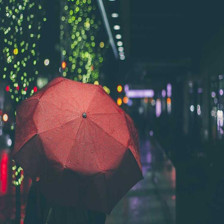

In [15]:
img = Image.open('random_img/umbrella.jpg')
img = img.resize((512,512))

img.resize((224, 224))

In [16]:
dino_features = process_image(img, model_dino, dino_transform)
clip_img_features = process_image(img, model_clip.visual, preprocess_clip)

sae_outputs = {
    "dino": {
        "global": sae_model_global({'dino': dino_features}),
        "local": sae_model_local({'dino': dino_features}),
        "no_cross": sae_model_no_cross({'dino': dino_features})
    },
    "clip_img": {
        "global": sae_model_global({'clip_img': clip_img_features}),
        "local": sae_model_local({'clip_img': clip_img_features}),
        "no_cross": sae_model_no_cross({'clip_img': clip_img_features})
    }
}


results_dict = create_results_dict(analysis_results, sae_outputs, preloaded_text_embs)

In [17]:
display_results_html(results_dict)

# Random Caption -> Image 

In [18]:
def find_similar_images(txt_emb, img_embs, top_k=5):
    if isinstance(txt_emb, torch.Tensor):
        txt_emb = csr_matrix(txt_emb.detach().cpu().numpy())
    
    if isinstance(img_embs, torch.Tensor):
        img_embs = csr_matrix(img_embs.detach().cpu().numpy())
    
    # Compute cosine similarities efficiently with sparse matrices
    similarities = cosine_similarity(txt_emb, img_embs).flatten()
    
    # Get top-k indices and return with similarities
    top_indices = np.argpartition(similarities, -top_k)[-top_k:]
    top_indices = top_indices[np.argsort(similarities[top_indices])[::-1]]
    
    return [(idx, similarities[idx]) for idx in top_indices]

In [19]:
def process_text_query(text, preloaded_features, top_k=5):
    text_tokens = clip_tokenizer(text).to(device)
    clip_txt_features = model_clip.encode_text(text_tokens)
    clip_txt_features = torch.nn.functional.normalize(clip_txt_features)
    sae_outputs = {
        "CLIP_TXT": {
            "Global Model": sae_model_global({'clip_txt': clip_txt_features}),
            "Local Model": sae_model_local({'clip_txt': clip_txt_features}),
#             "No Cross Model": sae_model_no_cross({'clip_txt': clip_txt_features})
        }
    }
    
    results_dict = {"DINO": {}, "CLIP": {}}
    
    for model_name in ["Global Model", "Local Model"]:#, "No Cross Model"]:      
        text_emb = sae_outputs["CLIP_TXT"][model_name]['sparse_codes_clip_txt'].squeeze(0)
        
        # Use preloaded features instead of expensive calls
        dino_embs = preloaded_features[model_name]['dino']
        clip_img_embs = preloaded_features[model_name]['clip_img']
        
        results_dict["DINO"][model_name] = find_similar_images(text_emb, dino_embs, top_k=top_k)
        results_dict["CLIP"][model_name] = find_similar_images(text_emb, clip_img_embs, top_k=top_k)    
    
    return clip_txt_features, results_dict

In [20]:
def visualize_text_to_images(text, text_features, results_dict, dataset, target_size=(512, 512), plot_title=True,
                             border_width=10, padding=5, use_center_crop=True):
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.patches import Rectangle
    
    models_config = [
        {"name": "Global TopK (DINO)", "feature": "DINO", "model": "Global Model"},
        {"name": "Local TopK (DINO)", "feature": "DINO", "model": "Local Model"},
        {"name": "Global TopK (CLIP)", "feature": "CLIP", "model": "Global Model"},
        {"name": "Local TopK (CLIP)", "feature": "CLIP", "model": "Local Model"}
    ]
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    def resize_and_border(img, add_border=False, rank=None):
        if not isinstance(img, np.ndarray):
            img = np.array(img)
        
        if len(img.shape) == 2:
            img = np.stack([img, img, img], axis=2)
        
        from scipy.ndimage import zoom
        h, w = img.shape[:2]
        
        if use_center_crop:
            # Center crop to preserve aspect ratio
            target_h, target_w = target_size
            original_aspect = w / h
            target_aspect = target_w / target_h
            
            if original_aspect > target_aspect:
                # Image is too wide, crop width
                new_w = int(h * target_aspect)
                start_w = (w - new_w) // 2
                img = img[:, start_w:start_w + new_w]
            elif original_aspect < target_aspect:
                # Image is too tall, crop height
                new_h = int(w / target_aspect)
                start_h = (h - new_h) // 2
                img = img[start_h:start_h + new_h, :]
            
            h, w = img.shape[:2]
        
        zoom_h, zoom_w = target_size[0]/h, target_size[1]/w
        resized_img = np.zeros((target_size[0], target_size[1], 3), dtype=np.uint8)
        for c in range(3):
            resized_img[:, :, c] = zoom(img[:, :, c], (zoom_h, zoom_w), order=1)
        
        # Add rank number using simple overlay - make size relative to image
        if rank is not None:
            # Calculate circle size as percentage of image size
            base_size = min(target_size[0], target_size[1])
            radius = max(12, int(base_size * 0.06))  # 6% of smaller dimension, min 12px
            margin = max(5, int(base_size * 0.02))   # 2% margin from edge, min 5px
            
            y_center = margin + radius
            x_center = margin + radius
            
            y, x = np.ogrid[:target_size[0], :target_size[1]]
            mask = (x - x_center)**2 + (y - y_center)**2 <= radius**2
            resized_img[mask] = [255, 255, 255]  # White circle
            
            # Add black border to circle
            border_width = max(1, radius // 12)  # Border width scales with radius
            border_mask = ((x - x_center)**2 + (y - y_center)**2 <= (radius + border_width)**2) & \
                         ((x - x_center)**2 + (y - y_center)**2 > radius**2)
            resized_img[border_mask] = [0, 0, 0]  # Black border
        
        return resized_img, rank
    
    def create_3x3_grid(img_indices, pad):
        grid_images = []
        rank_positions = []
        
        for i, idx in enumerate(img_indices):
            img = dataset[idx]['image']
            resized_img, rank = resize_and_border(img, add_border=False, rank=i+1)
            grid_images.append(resized_img)
            rank_positions.append(rank)
        
        if pad == 0:
            rows = []
            for i in range(3):
                row = np.hstack((grid_images[i*3], grid_images[i*3+1], grid_images[i*3+2]))
                rows.append(row)
            grid = np.vstack(rows)
            return grid, rank_positions
        
        single_height, single_width = target_size
        grid_height = 3 * single_height + 2 * pad
        grid_width = 3 * single_width + 2 * pad
        
        grid = np.ones((grid_height, grid_width, 3), dtype=np.uint8) * 255
        
        for i in range(3):
            for j in range(3):
                idx = i * 3 + j
                start_h = i * (single_height + pad)
                end_h = start_h + single_height
                start_w = j * (single_width + pad)
                end_w = start_w + single_width
                grid[start_h:end_h, start_w:end_w] = grid_images[idx]
        
        return grid, rank_positions
    
    for col_idx, config in enumerate(models_config):
        top_similarities = results_dict[config["feature"]][config["model"]]
        indices = [idx for idx, _ in top_similarities[:9]]  # Take top 9 for 3x3 grid
        
        ax = axes[col_idx]
        if plot_title:
            ax.set_title(config["name"], fontsize=16, fontweight='normal')
        
        grid, ranks = create_3x3_grid(indices, padding)
        ax.imshow(grid)
        
        # Calculate text positions and font size relative to image size
        base_size = min(target_size[0], target_size[1])
        font_size = max(6, int(base_size * 0.01))  # 1% of smaller dimension, min 6pt
        margin = max(5, int(base_size * 0.02))
        radius = max(12, int(base_size * 0.06))
        text_offset = margin + radius
        
        if padding == 0:
            positions = []
            for i in range(3):
                for j in range(3):
                    x = j * target_size[1] + text_offset
                    y = i * target_size[0] + text_offset
                    positions.append((x, y))
        else:
            positions = []
            for i in range(3):
                for j in range(3):
                    x = j * (target_size[1] + padding) + text_offset
                    y = i * (target_size[0] + padding) + text_offset
                    positions.append((x, y))
        
        for i, (x, y) in enumerate(positions):
            ax.text(x, y, str(i+1), fontsize=font_size, fontweight='bold', color='black', 
                   ha='center', va='center')
        
        ax.axis('off')
    
    plt.tight_layout(pad=0.5)
    return fig

In [21]:
from sklearn.preprocessing import normalize

analysis_results = {
    "Global Model": analysis_results_global,
    "Local Model": analysis_results_local,
#     "No Cross Model": analysis_results_no_cross
}

preloaded_features = {
    model_name: {
        'dino': normalize(
            model_results.get_all_features_for_stream('dino', 'latents', return_sparse=True), norm='l2', axis=1),
        'clip_img': normalize(
            model_results.get_all_features_for_stream('clip_img', 'latents', return_sparse=True), 
            norm='l2', axis=1)
    }
    for model_name, model_results in analysis_results.items()
}

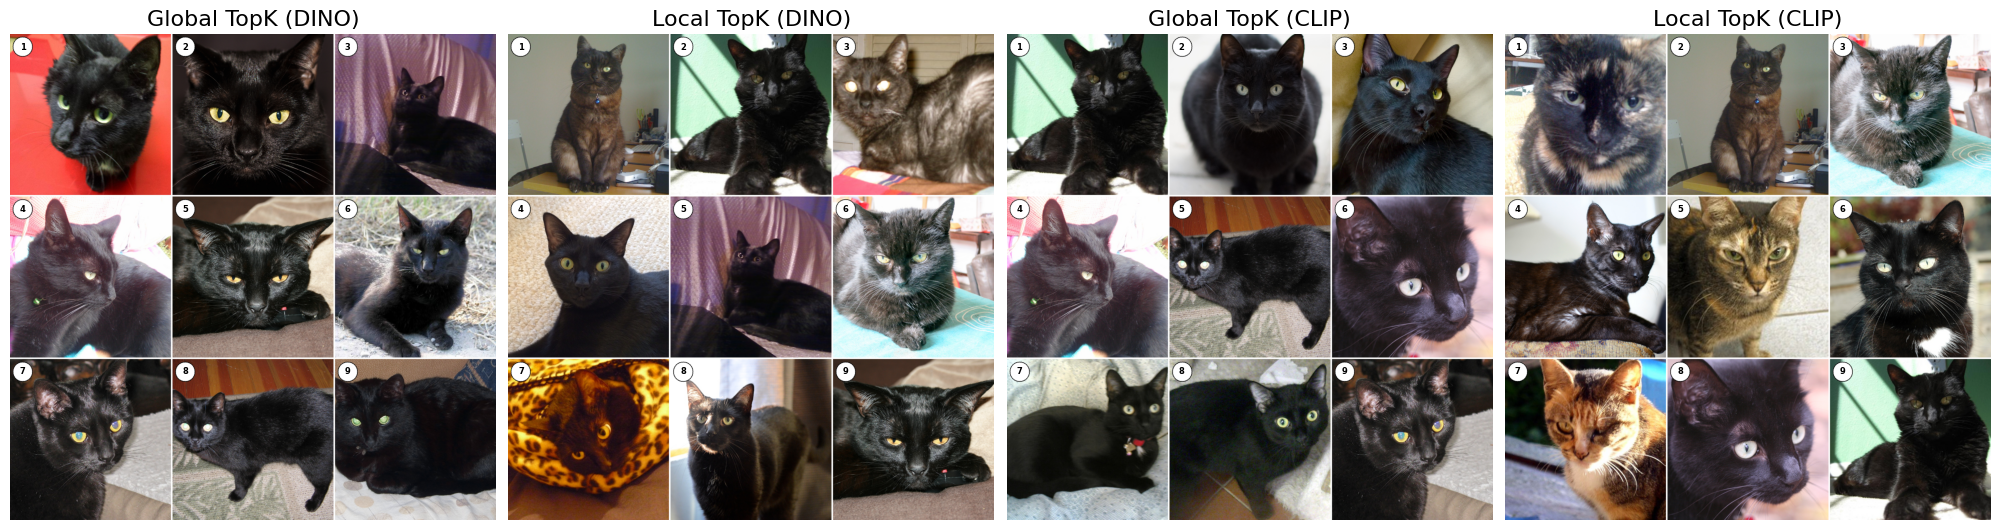

In [22]:
text = "Black cat"
clip_txt_features, results_dict = process_text_query(text, preloaded_features, top_k=10)
fig = visualize_text_to_images(text, clip_txt_features, results_dict, dataset, plot_title=True)

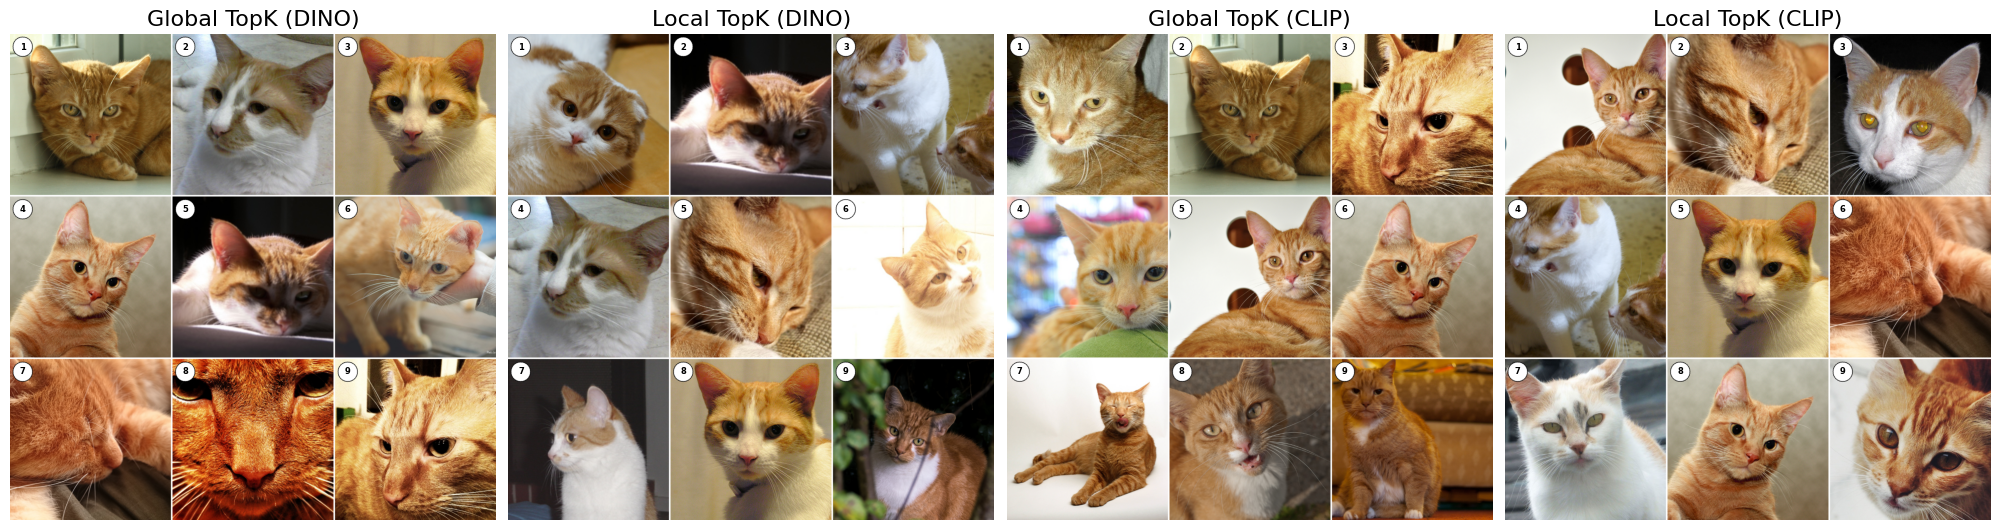

In [23]:
text = "Orange cat"
clip_txt_features, results_dict = process_text_query(text, preloaded_features, top_k=10)
fig = visualize_text_to_images(text, clip_txt_features, results_dict, dataset, plot_title=True)

# Random Image -> Image

In [24]:
def plot_similar_images_live(query_img, k=5, show_title=True, show_plot=False):
    """
    Cross-modal image retrieval with 4×k layout: DINO (Global/Local) + CLIP (Global/Local)
    Returns PIL Image instead of showing plot - LIVE VERSION
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    import io
    from matplotlib.patches import Rectangle
    from scipy.sparse import csr_matrix
    from sklearn.metrics.pairwise import cosine_similarity
    
    def resize_image(img, size=(224, 224)):
        if isinstance(img, Image.Image):
            return img.resize(size, Image.Resampling.LANCZOS)
        else:
            img_pil = Image.fromarray(img)
            return img_pil.resize(size, Image.Resampling.LANCZOS)
    
    def get_top_k_similar(query_vector, target_matrix, k):
        # Convert tensor to sparse matrix to match target_matrix format
        if isinstance(query_vector, torch.Tensor):
            query_vector = csr_matrix(query_vector.detach().cpu().numpy())
        
        # Use cosine similarity like in the second code
        similarities = cosine_similarity(query_vector, target_matrix).flatten()
        top_indices = np.argsort(similarities)[::-1][:k]
        return top_indices
    
    # LIVE PROCESSING: Get query vectors from external image
    dino_features = process_image(query_img, model_dino, dino_transform)
    clip_img_features = process_image(query_img, model_clip.visual, preprocess_clip)
    
    # Get SAE embeddings
    sae_global_dino = sae_model_global({'dino': dino_features})['sparse_codes_dino'].squeeze(0)
    sae_local_dino = sae_model_local({'dino': dino_features})['sparse_codes_dino'].squeeze(0)
    sae_global_clip = sae_model_global({'clip_img': clip_img_features})['sparse_codes_clip_img'].squeeze(0)
    sae_local_clip = sae_model_local({'clip_img': clip_img_features})['sparse_codes_clip_img'].squeeze(0)
    
    # Create the 4×k retrieved images plot
    fig_retrieved, axes = plt.subplots(4, k+1, figsize=(k*2+1, 8), 
                                      gridspec_kw={
                                          'width_ratios': [1]*k + [0.3],
                                          'hspace': 0.02,
                                          'wspace': 0.05
                                      })
    # LIVE VERSION: Replace analysis_results with live embeddings and preloaded features
    configurations = [
        ('DINO Global', sae_global_dino, preloaded_features['Global Model']['clip_img']),
        ('DINO Local', sae_local_dino, preloaded_features['Local Model']['clip_img']),
        ('CLIP Global', sae_global_clip, preloaded_features['Global Model']['dino']),
        ('CLIP Local', sae_local_clip, preloaded_features['Local Model']['dino'])
    ]
    
    for row, (model_name, query_vector, target_matrix) in enumerate(configurations):
        top_k_indices = get_top_k_similar(query_vector, target_matrix, k)
        
        for col, idx in enumerate(top_k_indices):
            img_resized = resize_image(dataset[idx]['image'])
            axes[row, col].imshow(img_resized)
            axes[row, col].axis('off')
        
        # Add model name
        axes[row, -1].text(0.5, 0.5, model_name, transform=axes[row, -1].transAxes, 
                          rotation=90, va='center', ha='center', fontsize=16, fontweight='normal')
        axes[row, -1].axis('off')
    
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0.02, wspace=0.05)
    
    # Render 4×k plot to memory
    buf = io.BytesIO()
    fig_retrieved.savefig(buf, format='png', bbox_inches='tight', dpi=100, pad_inches=0)
    buf.seek(0)
    retrieved_img = Image.open(buf).copy()
    plt.close(fig_retrieved)
    buf.close()
    
    # Create final combined plot
    retrieved_width, retrieved_height = retrieved_img.size
    original_size = retrieved_height
    width_ratio = [original_size, retrieved_width]
    
    fig_final = plt.figure(figsize=(18, 8))
    gs = fig_final.add_gridspec(1, 2, width_ratios=width_ratio, wspace=0.01)
    
    # Original image - LIVE VERSION: use query_img instead of dataset[img_index]
    ax1 = fig_final.add_subplot(gs[0, 0])
    original_img = resize_image(query_img, size=(original_size, original_size))
    ax1.imshow(original_img)
    ax1.axis('off')
    
    if show_title:
        ax1.set_title('Query', fontsize=18, fontweight='normal')
    
    # Retrieved images
    ax2 = fig_final.add_subplot(gs[0, 1])
    ax2.imshow(retrieved_img)
    ax2.axis('off')
    
    # Add ranking numbers if requested
    if show_title:
        total_width_ratio = k + 0.3
        for col in range(k):
            x_pos = (col + 0.5) / total_width_ratio
            ax2.text(x_pos, 1.02, f'{col+1}', transform=ax2.transAxes, 
                    ha='center', va='bottom', fontsize=18, fontweight='normal')
    
    if show_plot:
        plt.show()
    
    # Return as PIL Image
    buf_final = io.BytesIO()
    fig_final.savefig(buf_final, format='png', bbox_inches='tight', dpi=100, pad_inches=0)
    buf_final.seek(0)
    final_img = Image.open(buf_final).copy()
    plt.close(fig_final)
    buf_final.close()
    
    return final_img

def stack_plot_images(plot_images, spacing=0):
    """
    Stack multiple plot images vertically and return matplotlib figure
    
    Args:
        plot_images: List of PIL Images to stack
        spacing: Pixels of white space between images (default: 0)
    
    Returns:
        matplotlib.figure.Figure
    """
    import matplotlib.pyplot as plt
    from PIL import Image
    
    if not plot_images:
        return None
    
    # Calculate dimensions with spacing
    total_width = plot_images[0].width
    total_height = int(sum(img.height for img in plot_images) + spacing * (len(plot_images) - 1))
    
    # Create combined image with white background
    combined_img = Image.new('RGB', (total_width, total_height), 'white')
    
    # Paste images with spacing
    y_offset = 0
    for i, img in enumerate(plot_images):
        combined_img.paste(img, (0, y_offset))
        y_offset += img.height + spacing
    
    # Create figure and display combined image
    fig = plt.figure(figsize=(20, len(plot_images) * 6))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(combined_img)
    ax.axis('off')
    plt.tight_layout()
    
    return fig

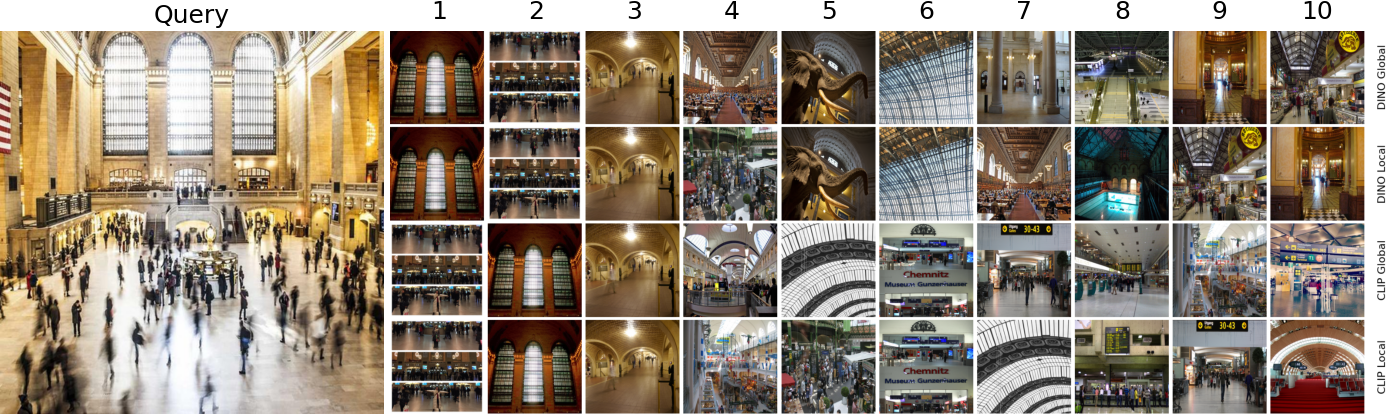

In [25]:
img = Image.open('random_img/train_station.jpg').resize((512, 512))
plot_result = plot_similar_images_live(img, k=10, show_title=True)
plot_result